In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.constants as const
from cupy import isnan
from scipy.signal import convolve
from scipy.fft import rfft, irfft, rfftfreq
from scipy import signal
from scipy.interpolate import interp1d
from scipy.io import savemat

# 常量定义
G = const.G # 万有引力常数, m^3 kg^-1 s^-2
c = const.c  # 光速, m/s
msun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

m1：34.26
m2：32.49
啁啾质量：29.04
采样率：16384
总样本数：524288
源距离：410.0000
天体透镜质量：1.0000e+07
y:0.6000


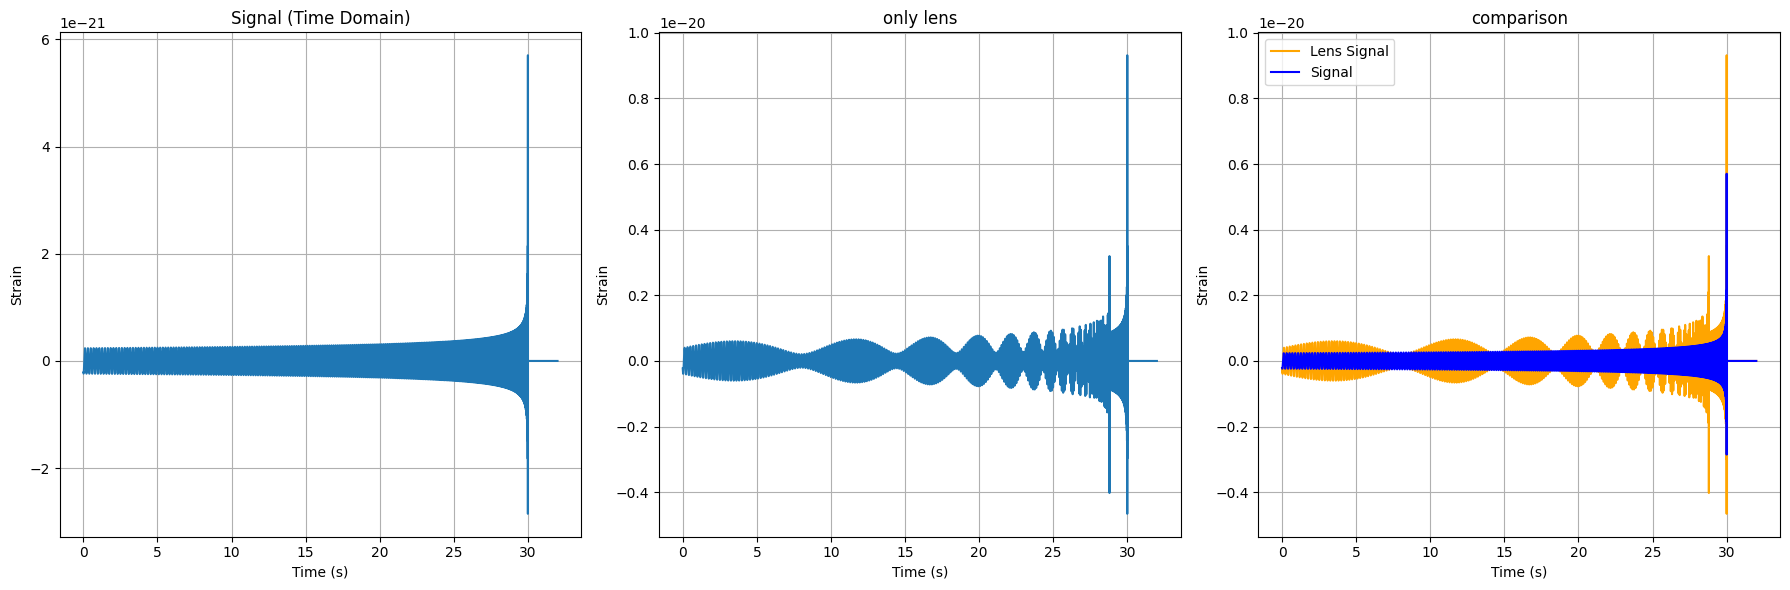

In [6]:
# 初始参数 - GW150914
m1 = 34.26          # 第一个黑洞质量（太阳质量）
m2 = 32.49         # 第二个黑洞质量（太阳质量）
# M_chirp = (m1 * m2 / (m1 + m2) ** 2) ** (3/5) * (m1 + m2)  # 啁啾质量
M_chirp = (m1 * m2) ** (3/5) / (m1 + m2) ** (1/5)
M_chirp = M_chirp * msun  # 转换为kg

# 透镜参数
mlz = 1e7 * msun  # 透镜质量
y = 0.6       # 影响参数

# 采样参数 - 与LIGO一致
fs = 16384       # 采样率调整为LIGO的标准采样率
dt = 1/fs
t = np.arange(0, 32, dt)  # 时间范围调整，使其更加聚焦于合并前的最后阶段
t_len = t[-1] - t[0]
N = len(t)

# 引力波参数 - 调整以匹配GW150914
tc = 30      # 合并时间，选择使信号在最后时刻达到峰值
phi_c = 0     

# SIS透镜参数
r = 410 * 1e6 * pc   # 源距离 (410 Mpc)

# 函数：引力波波形生成（啁啾信号）
def generate_gw_signal(t):
    # 确保在合并前截止
    valid_idx = t < tc
    t_valid = t[valid_idx]
    # 计算Θ(t)，控制信号的频率演化
    Theta = c**3 * (tc - t_valid) / (5 * G * M_chirp)
    # 计算振幅部分
    A = (G * M_chirp / (c**2 * r)) * Theta**(-1/4)
    
    # 原始相位计算
    phase = 2 * phi_c - 2 * Theta**(5/8)
    
    # 计算波形
    h = np.zeros_like(t)
    h[valid_idx] = A * np.cos(phase)
    return h

## 函数：透镜放大因子（时域方法2）
def lens_time(h_original, t, y):
    # 计算放大因子
    mu_plus = np.sqrt(1 + 1/y)  # 主像
    mu_minus = np.sqrt(-1 + 1/y) if y < 1 else 0  # 次像
    
    # 计算物理时间延迟
    td = 2 * y  # 秒
    # 创建插值函数
    interp_func = interp1d(t, h_original, kind='cubic', bounds_error=False, fill_value=0)
    # 创建延迟时间点
    t_delayed = t +td 
    
    # 计算延迟信号
    h_delayed = interp_func(t_delayed)
    
    # 透镜化效应：原始信号和延迟信号的组合
    h_lensed = mu_plus * h_original
    
    # 只有在y<1时才有次像
    if y < 1:
        h_lensed = h_lensed - mu_minus * h_delayed  # 次像有π相位差(负号)
    return h_lensed
# 计算引力波信号
h = generate_gw_signal(t)

h_lens = lens_time(h, t, y)
# 输出计算的时间延迟

print(f'm1：{m1}')
print(f'm2：{m2}')
print(f'啁啾质量：{M_chirp / msun:.2f}')
print(f'采样率：{fs}')
print(f'总样本数：{N}')
print(f'源距离：{r / 1e6 / pc :.4f}')
print(f'天体透镜质量：{mlz / msun:.4e}')
print(f"y:{y:.4f}")

# 绘制原始信号的时域和频域表示
plt.figure(figsize=(18, 6)) 
# 时域原始信号
plt.subplot(131)
plt.plot(t, h)
plt.title('Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)
plt.subplot(132)
plt.plot(t, h_lens, label='Lens Signal(T)')
plt.title('only lens')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)
plt.tight_layout()
plt.subplot(133)
plt.plot(t, h_lens,'orange', label='Lens Signal')
plt.plot(t, h,'b',label='Signal')
plt.title('comparison')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# h_freqs = np.fft.fftfreq(len(h),t[1] - t[0])
# f_h = np.fft.fft(h)
# fig = plt.figure(figsize=(18, 6))
# plt.plot(h_freqs, np.real(f_h))
# plt.yscale('log')
# plt.xscale('log')
# plt.show()


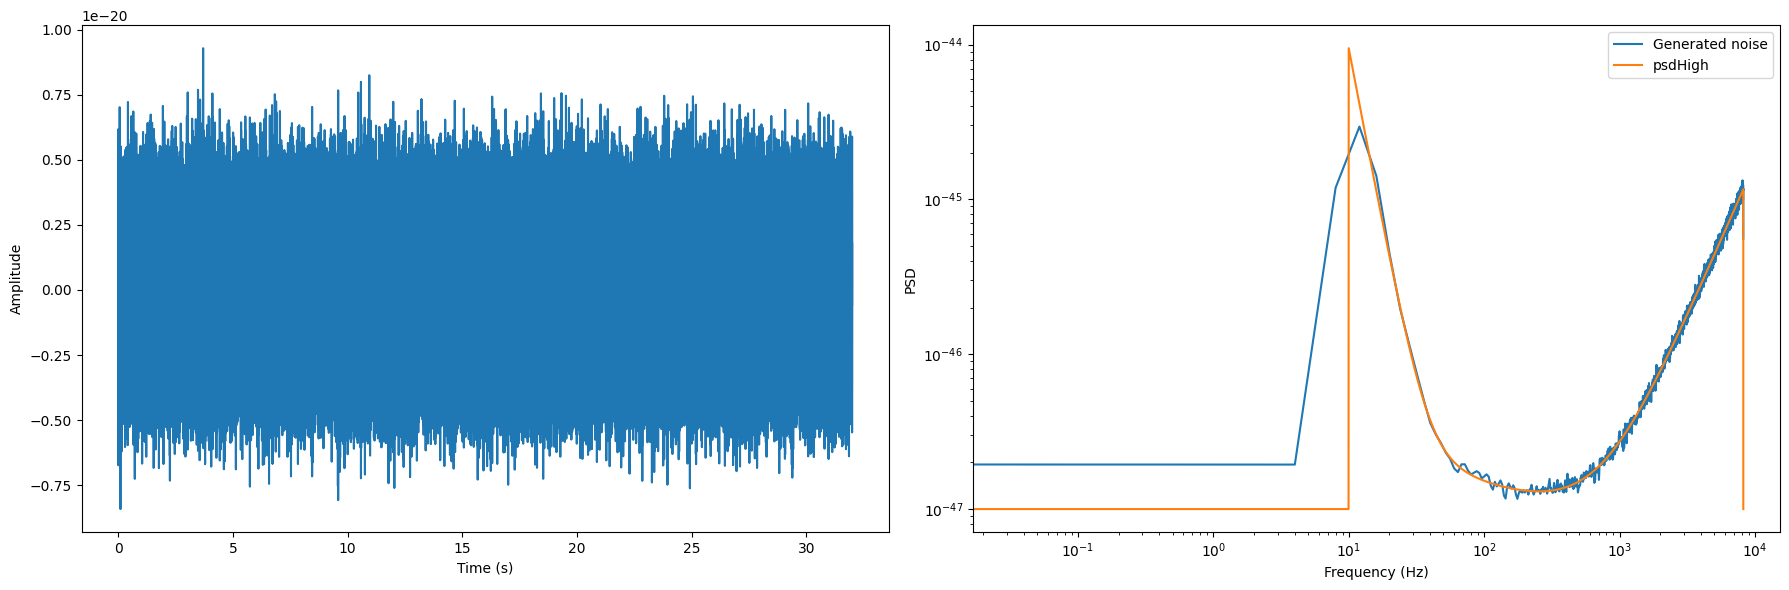

In [7]:
import pycbc.noise
import pycbc.psd
from scipy.signal import welch

fs = 16384  # This seems to be missing in your code
N = 32 * fs  # Total number of samples for 20 seconds
flow = 10
delta_f = 1 / 32
delta_t = 1 / fs
t = np.arange(0, N) * delta_t

# Generate PSD and noise
f_len = int(N // 2) + 1
psdHigh = pycbc.psd.aLIGOZeroDetHighPower(f_len, delta_f, flow)
psdHigh = np.maximum(psdHigh, 1e-47)
output_noise = pycbc.noise.noise_from_psd(N, delta_t, psdHigh)

# Plot time domain
fig = plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(t, output_noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Calculate PSD with Welch method - use proper parameters
f, pxx = welch(output_noise, fs=fs, nperseg=4096, noverlap=2048, scaling='density')

# Convert PyCBC PSD to numpy array with correct frequency axis
psd_freq = np.arange(len(psdHigh)) * delta_f

# Plot frequency domain
plt.subplot(122)
plt.plot(f, pxx, label='Generated noise')
plt.plot(psd_freq, psdHigh, label='psdHigh')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.tight_layout()
plt.show()

savemat('noise.mat',{'noise':output_noise,'psd':psdHigh})

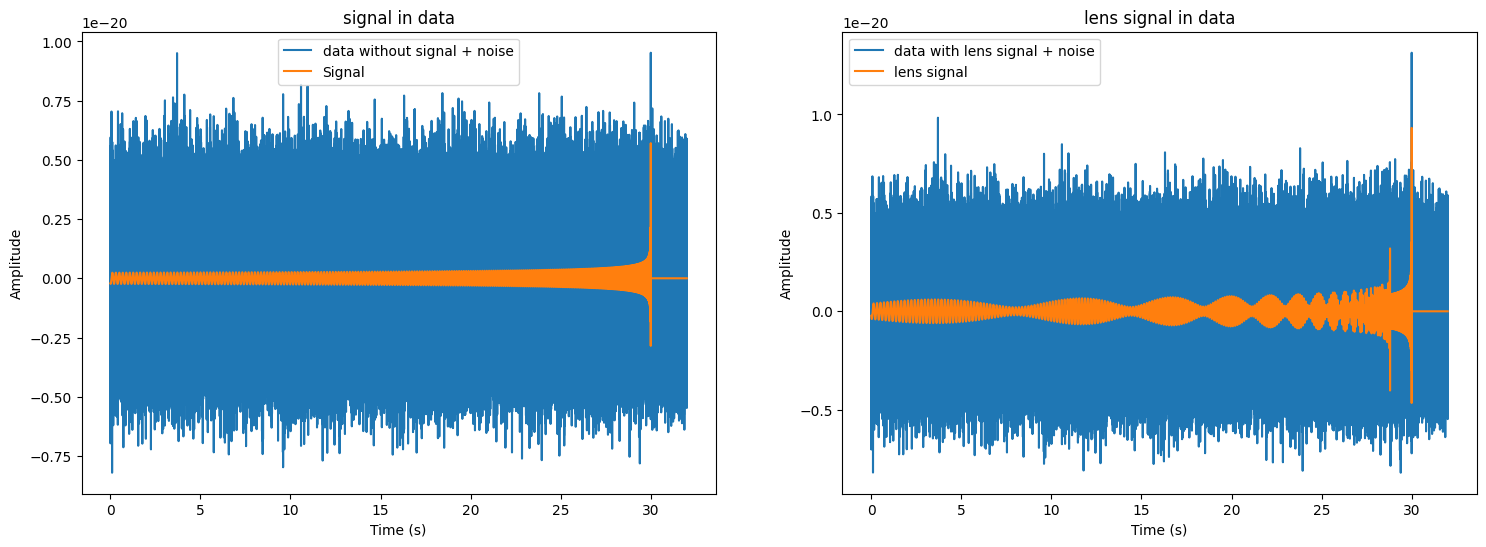

In [8]:
data = h + output_noise
data_lens = h_lens + output_noise
# data = h_windowed + output_noise
# data_lens = h_lens_windowed + output_noise

fig = plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(t, data, label='data without signal + noise')
# plt.plot(t, h_windowed, label='Signal')
plt.plot(t, h, label='Signal')
plt.title('signal in data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(122)
plt.plot(t,data_lens, label='data with lens signal + noise')
# plt.plot(t, h_lens_windowed, label='lens signal')
plt.plot(t, h_lens, label='lens signal')
plt.title('lens signal in data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

savemat('data_without_lens.mat',{'data':data,'samples':fs,'t0':t[0],'t1':t[-1]})
savemat('data.mat',{'data':data_lens,'samples':fs,'t0':t[0],'t1':t[-1]})
